# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][0].shape

([array([ 0.02262757, -0.0117639 , -0.04890319,  0.01120703]),
  0,
  array([ 0.02239229, -0.20615164, -0.04867905,  0.28806824]),
  1.0,
  0.0],
 (4,))

In [5]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.5191584671906826 -2.7515664333512344


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [36]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [37]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [38]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [39]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [40]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [41]:
# Initializing the memory with the pool of random exploration of the env.
goal = 500 # env-based, the total reward required for reaching the goal G
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [44]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the memory
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair

            sortedmemory = sorted(memory.buffer, key=lambda col:col[5], reverse=True)
            ratedbatch = [sortedmemory[idx] for idx in range(len(sortedmemory)//10)]
            batch = sample(batch_size=batch_size, ListArr=ratedbatch)
            #batch = [sortedmemory[idx] for idx in range(batch_size)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #rates = np.array([each[5] for each in batch])
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:22.0000 R:22.0 rate:0.0440 loss:1.0374 exploreP:0.9978
Episode:1 meanR:24.5000 R:27.0 rate:0.0540 loss:1.1223 exploreP:0.9952
Episode:2 meanR:20.6667 R:13.0 rate:0.0260 loss:1.1853 exploreP:0.9939
Episode:3 meanR:18.5000 R:12.0 rate:0.0240 loss:1.2326 exploreP:0.9927
Episode:4 meanR:17.8000 R:15.0 rate:0.0300 loss:1.2855 exploreP:0.9912
Episode:5 meanR:16.8333 R:12.0 rate:0.0240 loss:1.3489 exploreP:0.9901
Episode:6 meanR:18.2857 R:27.0 rate:0.0540 loss:1.3528 exploreP:0.9874
Episode:7 meanR:18.7500 R:22.0 rate:0.0440 loss:1.3471 exploreP:0.9853
Episode:8 meanR:17.8889 R:11.0 rate:0.0220 loss:1.3025 exploreP:0.9842
Episode:9 meanR:19.0000 R:29.0 rate:0.0580 loss:1.3205 exploreP:0.9814
Episode:10 meanR:18.8182 R:17.0 rate:0.0340 loss:1.2990 exploreP:0.9797
Episode:11 meanR:22.5833 R:64.0 rate:0.1280 loss:1.3149 exploreP:0.9735
Episode:12 meanR:22.0000 R:15.0 rate:0.0300 loss:1.3669 exploreP:0.9721
Episode:13 meanR:21.6429 R:17.0 rate:0.0340 loss:1.3689 exploreP:0.9705
Ep

Episode:112 meanR:21.5800 R:10.0 rate:0.0200 loss:508.4102 exploreP:0.7853
Episode:113 meanR:21.5200 R:11.0 rate:0.0220 loss:450.2904 exploreP:0.7845
Episode:114 meanR:21.4800 R:23.0 rate:0.0460 loss:397.0553 exploreP:0.7827
Episode:115 meanR:21.6100 R:50.0 rate:0.1000 loss:393.2559 exploreP:0.7789
Episode:116 meanR:21.6200 R:20.0 rate:0.0400 loss:294.2444 exploreP:0.7773
Episode:117 meanR:21.4100 R:14.0 rate:0.0280 loss:429.2126 exploreP:0.7762
Episode:118 meanR:21.3100 R:14.0 rate:0.0280 loss:427.6034 exploreP:0.7752
Episode:119 meanR:21.2800 R:14.0 rate:0.0280 loss:458.7368 exploreP:0.7741
Episode:120 meanR:21.1700 R:14.0 rate:0.0280 loss:357.5798 exploreP:0.7730
Episode:121 meanR:21.0900 R:19.0 rate:0.0380 loss:334.9002 exploreP:0.7716
Episode:122 meanR:21.2600 R:33.0 rate:0.0660 loss:382.0152 exploreP:0.7691
Episode:123 meanR:21.2100 R:10.0 rate:0.0200 loss:292.3059 exploreP:0.7683
Episode:124 meanR:21.1500 R:13.0 rate:0.0260 loss:164.1771 exploreP:0.7673
Episode:125 meanR:21.2400

Episode:222 meanR:19.2100 R:37.0 rate:0.0740 loss:73.1820 exploreP:0.6364
Episode:223 meanR:19.3200 R:21.0 rate:0.0420 loss:52.1948 exploreP:0.6351
Episode:224 meanR:19.6900 R:50.0 rate:0.1000 loss:66.0682 exploreP:0.6320
Episode:225 meanR:19.6000 R:15.0 rate:0.0300 loss:61.8895 exploreP:0.6310
Episode:226 meanR:19.8800 R:39.0 rate:0.0780 loss:80.0292 exploreP:0.6286
Episode:227 meanR:20.3300 R:56.0 rate:0.1120 loss:61.2384 exploreP:0.6252
Episode:228 meanR:20.4600 R:26.0 rate:0.0520 loss:59.6773 exploreP:0.6236
Episode:229 meanR:20.5700 R:26.0 rate:0.0520 loss:75.7055 exploreP:0.6220
Episode:230 meanR:20.7400 R:28.0 rate:0.0560 loss:63.0548 exploreP:0.6203
Episode:231 meanR:20.9600 R:46.0 rate:0.0920 loss:62.0830 exploreP:0.6175
Episode:232 meanR:20.9900 R:14.0 rate:0.0280 loss:57.1529 exploreP:0.6166
Episode:233 meanR:21.1300 R:38.0 rate:0.0760 loss:60.5467 exploreP:0.6143
Episode:234 meanR:21.4200 R:56.0 rate:0.1120 loss:53.1634 exploreP:0.6109
Episode:235 meanR:21.5500 R:30.0 rate:

Episode:333 meanR:55.0000 R:82.0 rate:0.1640 loss:57.0982 exploreP:0.3587
Episode:334 meanR:54.8400 R:40.0 rate:0.0800 loss:55.6189 exploreP:0.3573
Episode:335 meanR:55.2700 R:73.0 rate:0.1460 loss:55.0490 exploreP:0.3547
Episode:336 meanR:55.5300 R:90.0 rate:0.1800 loss:58.1280 exploreP:0.3517
Episode:337 meanR:55.7800 R:61.0 rate:0.1220 loss:50.5826 exploreP:0.3496
Episode:338 meanR:56.2800 R:88.0 rate:0.1760 loss:47.8433 exploreP:0.3466
Episode:339 meanR:57.0900 R:99.0 rate:0.1980 loss:59.8899 exploreP:0.3433
Episode:340 meanR:56.6400 R:62.0 rate:0.1240 loss:46.3449 exploreP:0.3412
Episode:341 meanR:57.0100 R:74.0 rate:0.1480 loss:50.8546 exploreP:0.3388
Episode:342 meanR:57.2000 R:55.0 rate:0.1100 loss:53.7889 exploreP:0.3370
Episode:343 meanR:57.3700 R:63.0 rate:0.1260 loss:56.6313 exploreP:0.3349
Episode:344 meanR:57.3200 R:52.0 rate:0.1040 loss:54.9995 exploreP:0.3332
Episode:345 meanR:56.7400 R:42.0 rate:0.0840 loss:58.2977 exploreP:0.3319
Episode:346 meanR:57.2100 R:73.0 rate:

Episode:443 meanR:168.9000 R:500.0 rate:1.0000 loss:5.7211 exploreP:0.0700
Episode:444 meanR:173.3800 R:500.0 rate:1.0000 loss:5.2659 exploreP:0.0671
Episode:445 meanR:177.9600 R:500.0 rate:1.0000 loss:6.3985 exploreP:0.0643
Episode:446 meanR:182.2300 R:500.0 rate:1.0000 loss:6.5242 exploreP:0.0617
Episode:447 meanR:186.5100 R:500.0 rate:1.0000 loss:7.8363 exploreP:0.0591
Episode:448 meanR:190.7600 R:500.0 rate:1.0000 loss:8.7361 exploreP:0.0567
Episode:449 meanR:195.2700 R:500.0 rate:1.0000 loss:7.6077 exploreP:0.0545
Episode:450 meanR:199.7700 R:500.0 rate:1.0000 loss:8.2597 exploreP:0.0523
Episode:451 meanR:203.8000 R:500.0 rate:1.0000 loss:9.1059 exploreP:0.0502
Episode:452 meanR:208.1100 R:500.0 rate:1.0000 loss:11.2240 exploreP:0.0483
Episode:453 meanR:212.6000 R:500.0 rate:1.0000 loss:10.9779 exploreP:0.0464
Episode:454 meanR:216.5800 R:500.0 rate:1.0000 loss:11.6612 exploreP:0.0446
Episode:455 meanR:221.0800 R:500.0 rate:1.0000 loss:13.6055 exploreP:0.0429
Episode:456 meanR:224

Episode:553 meanR:37.9000 R:9.0 rate:0.0180 loss:270.9086 exploreP:0.0349
Episode:554 meanR:33.0100 R:11.0 rate:0.0220 loss:45.3480 exploreP:0.0349
Episode:555 meanR:28.1000 R:9.0 rate:0.0180 loss:213.8771 exploreP:0.0349
Episode:556 meanR:23.2000 R:10.0 rate:0.0200 loss:420.9368 exploreP:0.0348
Episode:557 meanR:22.3100 R:8.0 rate:0.0160 loss:5.3506 exploreP:0.0348
Episode:558 meanR:17.4000 R:9.0 rate:0.0180 loss:50.8991 exploreP:0.0348
Episode:559 meanR:12.4900 R:9.0 rate:0.0180 loss:85.4139 exploreP:0.0348
Episode:560 meanR:11.8400 R:10.0 rate:0.0200 loss:195.1543 exploreP:0.0348
Episode:561 meanR:11.7400 R:10.0 rate:0.0200 loss:543.0997 exploreP:0.0347
Episode:562 meanR:11.6500 R:8.0 rate:0.0160 loss:101.0194 exploreP:0.0347
Episode:563 meanR:11.5100 R:10.0 rate:0.0200 loss:4.2043 exploreP:0.0347
Episode:564 meanR:11.4000 R:8.0 rate:0.0160 loss:91.4429 exploreP:0.0347
Episode:565 meanR:11.3200 R:10.0 rate:0.0200 loss:273.2151 exploreP:0.0346
Episode:566 meanR:11.2400 R:10.0 rate:0.

Episode:665 meanR:9.4100 R:11.0 rate:0.0220 loss:184.9051 exploreP:0.0324
Episode:666 meanR:9.4100 R:10.0 rate:0.0200 loss:556.1592 exploreP:0.0324
Episode:667 meanR:9.4100 R:9.0 rate:0.0180 loss:612.0527 exploreP:0.0324
Episode:668 meanR:9.3900 R:8.0 rate:0.0160 loss:499.3898 exploreP:0.0324
Episode:669 meanR:9.3900 R:10.0 rate:0.0200 loss:920.7362 exploreP:0.0323
Episode:670 meanR:9.3800 R:9.0 rate:0.0180 loss:8.1486 exploreP:0.0323
Episode:671 meanR:9.3800 R:8.0 rate:0.0160 loss:404.4149 exploreP:0.0323
Episode:672 meanR:9.3800 R:9.0 rate:0.0180 loss:1075.3051 exploreP:0.0323
Episode:673 meanR:9.3800 R:10.0 rate:0.0200 loss:327.4897 exploreP:0.0323
Episode:674 meanR:9.3800 R:9.0 rate:0.0180 loss:1008.4389 exploreP:0.0322
Episode:675 meanR:9.3700 R:10.0 rate:0.0200 loss:1445.5717 exploreP:0.0322
Episode:676 meanR:9.3700 R:10.0 rate:0.0200 loss:442.0492 exploreP:0.0322
Episode:677 meanR:9.3800 R:10.0 rate:0.0200 loss:7.2974 exploreP:0.0322
Episode:678 meanR:9.3900 R:10.0 rate:0.0200 l

Episode:777 meanR:9.5000 R:10.0 rate:0.0200 loss:535.1560 exploreP:0.0302
Episode:778 meanR:9.5000 R:10.0 rate:0.0200 loss:15.9510 exploreP:0.0301
Episode:779 meanR:9.4800 R:8.0 rate:0.0160 loss:2340.7085 exploreP:0.0301
Episode:780 meanR:9.4900 R:10.0 rate:0.0200 loss:3053.0356 exploreP:0.0301
Episode:781 meanR:9.4600 R:8.0 rate:0.0160 loss:1606.4906 exploreP:0.0301
Episode:782 meanR:9.4800 R:11.0 rate:0.0220 loss:513.9671 exploreP:0.0301
Episode:783 meanR:9.5000 R:10.0 rate:0.0200 loss:2352.1050 exploreP:0.0301
Episode:784 meanR:9.5100 R:10.0 rate:0.0200 loss:1411.4498 exploreP:0.0300
Episode:785 meanR:9.4800 R:8.0 rate:0.0160 loss:709.9088 exploreP:0.0300
Episode:786 meanR:9.4600 R:9.0 rate:0.0180 loss:1210.1201 exploreP:0.0300
Episode:787 meanR:9.4600 R:9.0 rate:0.0180 loss:1639.3401 exploreP:0.0300
Episode:788 meanR:9.4400 R:10.0 rate:0.0200 loss:1324.0977 exploreP:0.0300
Episode:789 meanR:9.4600 R:10.0 rate:0.0200 loss:1363.4985 exploreP:0.0299
Episode:790 meanR:9.4600 R:10.0 rat

Episode:888 meanR:9.5900 R:10.0 rate:0.0200 loss:2222.8159 exploreP:0.0281
Episode:889 meanR:9.5900 R:10.0 rate:0.0200 loss:1875.2659 exploreP:0.0281
Episode:890 meanR:9.5800 R:9.0 rate:0.0180 loss:3904.4666 exploreP:0.0281
Episode:891 meanR:9.5700 R:9.0 rate:0.0180 loss:3161.6987 exploreP:0.0281
Episode:892 meanR:9.5800 R:10.0 rate:0.0200 loss:1823.9235 exploreP:0.0281
Episode:893 meanR:9.5700 R:10.0 rate:0.0200 loss:4797.5225 exploreP:0.0280
Episode:894 meanR:9.5600 R:10.0 rate:0.0200 loss:2567.3027 exploreP:0.0280
Episode:895 meanR:9.5500 R:10.0 rate:0.0200 loss:2332.8701 exploreP:0.0280
Episode:896 meanR:9.5600 R:10.0 rate:0.0200 loss:2927.7544 exploreP:0.0280
Episode:897 meanR:9.5400 R:9.0 rate:0.0180 loss:2774.3765 exploreP:0.0280
Episode:898 meanR:9.5500 R:10.0 rate:0.0200 loss:2154.4553 exploreP:0.0280
Episode:899 meanR:9.5500 R:9.0 rate:0.0180 loss:955.0724 exploreP:0.0279
Episode:900 meanR:9.5400 R:9.0 rate:0.0180 loss:958.6653 exploreP:0.0279
Episode:901 meanR:9.5300 R:10.0 

Episode:999 meanR:9.5800 R:8.0 rate:0.0160 loss:3121.6223 exploreP:0.0263
Episode:1000 meanR:9.5900 R:10.0 rate:0.0200 loss:5504.4404 exploreP:0.0263
Episode:1001 meanR:9.5900 R:10.0 rate:0.0200 loss:2908.8772 exploreP:0.0263
Episode:1002 meanR:9.6100 R:11.0 rate:0.0220 loss:2629.2717 exploreP:0.0263
Episode:1003 meanR:9.6200 R:9.0 rate:0.0180 loss:1347.0259 exploreP:0.0262
Episode:1004 meanR:9.6100 R:9.0 rate:0.0180 loss:1297.4598 exploreP:0.0262
Episode:1005 meanR:9.6000 R:10.0 rate:0.0200 loss:1188.3845 exploreP:0.0262
Episode:1006 meanR:9.6100 R:10.0 rate:0.0200 loss:4106.2725 exploreP:0.0262
Episode:1007 meanR:9.6200 R:11.0 rate:0.0220 loss:3745.6782 exploreP:0.0262
Episode:1008 meanR:9.6100 R:10.0 rate:0.0200 loss:1347.3689 exploreP:0.0262
Episode:1009 meanR:9.6100 R:10.0 rate:0.0200 loss:5380.6665 exploreP:0.0261
Episode:1010 meanR:9.6000 R:9.0 rate:0.0180 loss:23.4591 exploreP:0.0261
Episode:1011 meanR:9.5800 R:10.0 rate:0.0200 loss:2623.7834 exploreP:0.0261
Episode:1012 meanR:

Episode:1108 meanR:9.5200 R:9.0 rate:0.0180 loss:23.9880 exploreP:0.0247
Episode:1109 meanR:9.5000 R:8.0 rate:0.0160 loss:25.7717 exploreP:0.0247
Episode:1110 meanR:9.5100 R:10.0 rate:0.0200 loss:5693.2559 exploreP:0.0247


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

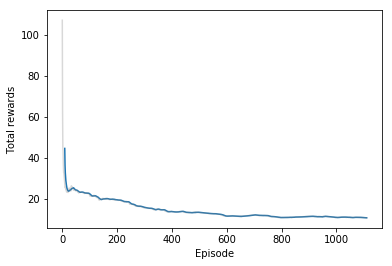

In [203]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

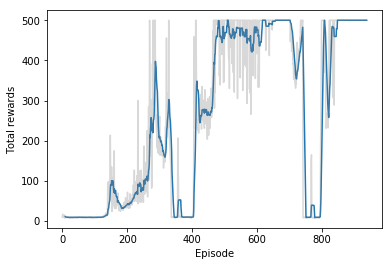

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

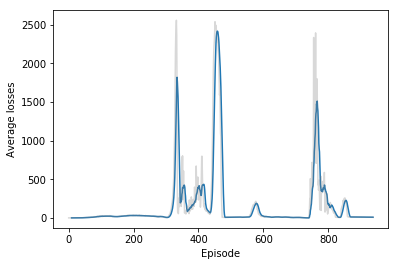

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.